In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import missingno as msno 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from glob import glob

In [2]:
# Data Loading and Preprocessing

In [3]:
os.chdir('data')
data_file_list = glob('*.csv')

In [4]:
ballers_dataframes = []
batters_dataframes = []
fielders_dataframes = []

for file in data_file_list:
    df = pd.read_csv(file)
    
    to_drop = [col_name for col_name in df.columns if 'Unnamed' in col_name]
    df.drop(to_drop,axis=1,inplace=True)
    
    if 'odi' in file.lower():
        df['match_type'] = 'odi'
    if 'test' in file.lower():
        df['match_type'] = 'test'
    if 't20' in file.lower():
        df['match_type'] = 't20'

    # Separate player names and regions
    player_names = df['Player'].apply(lambda x:x.split('(')[0].strip().upper().replace(')',''),)
    region_names = df['Player'].apply(lambda x:x.split('(')[-1].strip().upper().replace(')',''))
    
    df['Player'] = player_names
    df['Region'] = region_names
    
    df.drop_duplicates(inplace=True)
    
    if 'bow' in file.lower():
        ballers_dataframes.append(df)
    elif 'fielding' in file.lower():
        fielders_dataframes.append(df)
    else:        
        batters_dataframes.append(df)

In [5]:
ballers_data = pd.concat(ballers_dataframes,sort=True)
print(ballers_data.columns)
ballers_data.head()

Index(['10', '4', '5', 'Ave', 'BBI', 'BBM', 'Balls', 'Econ', 'Inns', 'Mat',
       'Mdns', 'Overs', 'Player', 'Region', 'Runs', 'SR', 'Span', 'Wkts',
       'match_type'],
      dtype='object')


,10,4,5,Ave,BBI,BBM,Balls,Econ,Inns,Mat,Mdns,Overs,Player,Region,Runs,SR,Span,Wkts,match_type
0,22.0,NaN,67,22.72,9/51,16/220,44039,2.47,230,133,NaN,NaN,M MURALITHARAN,ICC/SL,18180,55,1992-2010,800,test
1,10.0,NaN,37,25.41,8/71,12/128,40705,2.65,273,145,NaN,NaN,SK WARNE,AUS,17995,57.4,1992-2007,708,test
2,8.0,NaN,35,29.65,10/74,14/149,40850,2.69,236,132,NaN,NaN,A KUMBLE,INDIA,18355,65.9,1990-2008,619,test
3,3.0,NaN,27,27.04,7/42,11/71,32557,2.87,280,150,NaN,NaN,JM ANDERSON,ENG,15607,56.4,2003-2019,577,test
4,3.0,NaN,29,21.64,8/24,10/27,29248,2.49,243,124,NaN,NaN,GD MCGRATH,AUS,12186,51.9,1993-2007,563,test


In [6]:
batters_data = pd.concat(batters_dataframes,sort=True)
print(batters_data.columns)
batters_data.head()

Index(['0', '100', '4s', '50', '6s', 'Ave', 'BF', 'HS', 'Inns', 'Mat', 'NO',
       'Player', 'Region', 'Runs', 'SR', 'Span', 'match_type'],
      dtype='object')


,0,100,4s,50,6s,Ave,BF,HS,Inns,Mat,NO,Player,Region,Runs,SR,Span,match_type
0,20,49,NaN,96,NaN,44.83,21367,200*,452,463,41,SR TENDULKAR,INDIA,18426,86.23,1989-2012,odi
1,15,25,NaN,93,NaN,41.98,18048,169,380,404,41,KC SANGAKKARA,ASIA/ICC/SL,14234,78.86,2000-2015,odi
2,20,30,NaN,82,NaN,42.03,17046,164,365,375,39,RT PONTING,AUS/ICC,13704,80.39,1995-2012,odi
3,34,28,NaN,68,NaN,32.36,14725,189,433,445,18,ST JAYASURIYA,ASIA/SL,13430,91.2,1989-2011,odi
4,28,19,NaN,77,NaN,33.37,16020,144,418,448,39,DPMD JAYAWARDENE,ASIA/SL,12650,78.96,1998-2015,odi


In [7]:
fielders_data = pd.concat(fielders_dataframes,sort=True)
print(fielders_data.columns)
fielders_data.head()

Index(['Ct', 'Ct Fi', 'Ct Wk', 'D/I', 'Dis', 'Inns', 'MD', 'Mat', 'Player',
       'Region', 'Span', 'St', 'match_type'],
      dtype='object')


,Ct,Ct Fi,Ct Wk,D/I,Dis,Inns,MD,Mat,Player,Region,Span,St,match_type
0,402,19,383,1.261,501,397,5 (4ct 1st),404,KC SANGAKKARA,ASIA/ICC/SL,2000-2015,99,odi
1,417,0,417,1.65,472,286,6 (6ct 0st),287,AC GILCHRIST,AUS/ICC,1996-2008,55,odi
2,321,0,321,1.286,444,345,6 (5ct 1st),350,MS DHONI,ASIA/INDIA,2004-2019,123,odi
3,403,1,402,1.46,425,291,6 (6ct 0st),295,MV BOUCHER,AFR/SA,1998-2011,22,odi
4,214,0,214,1.322,287,217,5 (5ct 0st),219,MOIN KHAN,PAK,1990-2004,73,odi


In [8]:
erroneous_regions = set()
[erroneous_regions.add(regions) for regions in fielders_data[fielders_data.Region.str.contains('/')].Region.unique()]
[erroneous_regions.add(regions) for regions in batters_data[batters_data.Region.str.contains('/')].Region.unique()]
[erroneous_regions.add(regions) for regions in ballers_data[ballers_data.Region.str.contains('/')].Region.unique()]
erroneous_regions

{'AFG/GER',
 'AFG/ICC',
 'AFR/ICC/SA',
 'AFR/KENYA',
 'AFR/SA',
 'AFR/ZIM',
 'ASIA/BDESH',
 'ASIA/ICC/INDIA',
 'ASIA/ICC/PAK',
 'ASIA/ICC/SL',
 'ASIA/INDIA',
 'ASIA/PAK',
 'ASIA/SL',
 'AUS/ENG',
 'AUS/ICC',
 'AUS/ICC/NZ',
 'AUS/NL',
 'AUS/NZ',
 'AUS/SA',
 'AUS/WORLD',
 'BDESH/ICC/WORLD',
 'CAN/WI',
 'ENG/ICC',
 'ENG/INDIA',
 'ENG/IRE',
 'ENG/PNG',
 'ENG/SA',
 'ENG/SCOT',
 'ENG/WORLD',
 'HKG/NZ',
 'ICC/INDIA',
 'ICC/NEPAL',
 'ICC/NZ',
 'ICC/PAK',
 'ICC/SA',
 'ICC/SL',
 'ICC/SL/WORLD',
 'ICC/WI',
 'INDIA/PAK',
 'NL/SA',
 'NZ/WI',
 'NZ/WORLD',
 'SA/USA',
 'SA/WORLD',
 'SA/ZIM',
 'USA/WI',
 'WI/WORLD'}

In [9]:
replacements = {'AFG/GER' : 'AFG/GER',
 'AFG/ICC' : 'AFG',
 'AFR/ICC/SA' : 'SA',
 'AFR/KENYA' : 'KENYA',
 'AFR/SA' : 'SA',
 'AFR/ZIM' : 'ZIM',
 'ASIA/BDESH' : 'BDESH',
 'ASIA/ICC/INDIA' : 'INDIA',
 'ASIA/ICC/PAK' : 'PAK',
 'ASIA/ICC/SL' : 'SL',
 'ASIA/INDIA' : 'INDIA',
 'ASIA/PAK' : 'PAK',
 'ASIA/SL' : 'SL',
 'AUS/ENG' : 'AUS/ENG' ,
 'AUS/ICC' : 'AUS',
 'AUS/ICC/NZ' : 'AUS/NZ',
 'AUS/NL' : 'AUS/NL',
 'AUS/NZ' : 'AUS/NZ',
 'AUS/SA' : 'AUS/SA',
 'AUS/WORLD' : 'AUS',
 'BDESH/ICC/WORLD' : 'BDESH',
 'CAN/WI' : 'CAN/WI',
 'ENG/ICC' : 'ENG',
 'ENG/INDIA' : 'ENG/INDIA',
 'ENG/IRE' : 'ENG/IRE',
 'ENG/PNG' : 'ENG/PNG',
 'ENG/SA' : 'ENG/SA',
 'ENG/SCOT' : 'ENG/SCOT',
 'ENG/WORLD' : 'ENG',
 'HKG/NZ' : 'HKG/NZ',
 'ICC/INDIA' : 'INDIA',
 'ICC/NEPAL' : 'NEPAL',
 'ICC/NZ' : 'NZ',
 'ICC/PAK' : 'PAK',
 'ICC/SA' : 'SA',
 'ICC/SL' : 'SL',
 'ICC/SL/WORLD' : 'SL',
 'ICC/WI' : 'WI',
 'INDIA/PAK' : 'INDIA/PAK',
 'NL/SA' : 'NL/SA',
 'NZ/WI' : 'NZ/WI',
 'NZ/WORLD' : 'NZ',
 'SA/USA' : 'SA/USA',
 'SA/WORLD' : 'SA',
 'SA/ZIM' : 'SA/ZIM',
 'USA/WI' : 'USA/WI',
 'WI/WORLD' : 'WI'}

In [10]:
fielders_data.Region = fielders_data.Region.replace(replacements)
batters_data.Region = batters_data.Region.replace(replacements)
ballers_data.Region = ballers_data.Region.replace(replacements)

In [11]:
#Exploratory Data Analysis

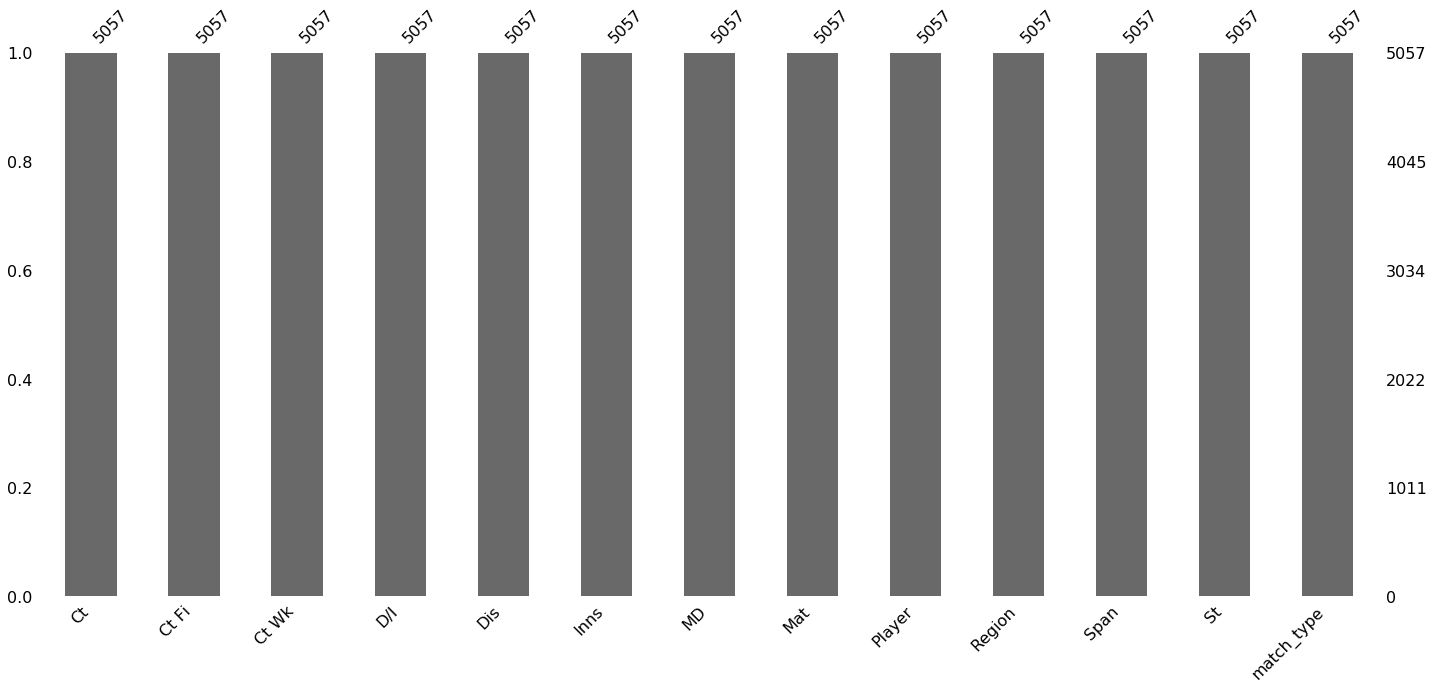

In [12]:
msno.bar(fielders_data);

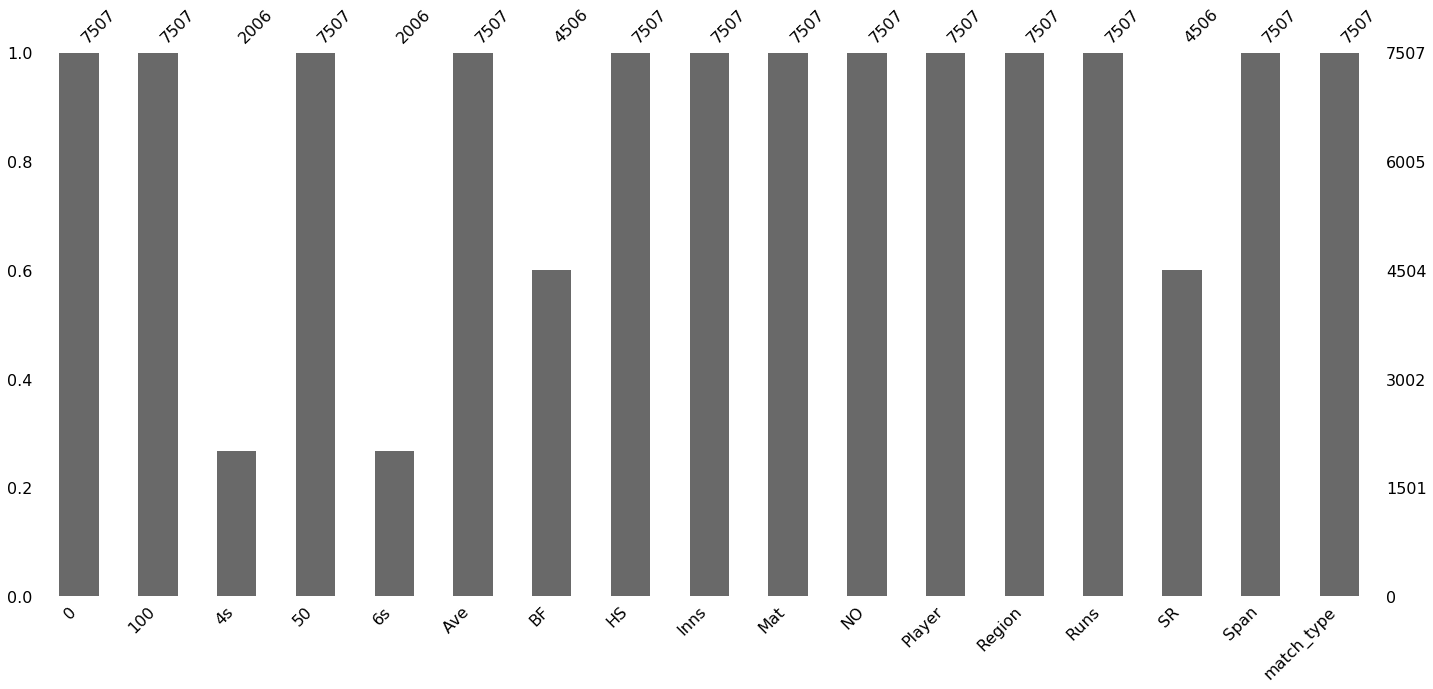

In [13]:
msno.bar(batters_data);

In [14]:
batters_data['4s'] = batters_data['4s'].fillna(0)
batters_data['6s'] = batters_data['6s'].fillna(0)
batters_data['BF'] = batters_data['BF'].fillna(0)
batters_data['SR'] = batters_data['SR'].fillna(0)

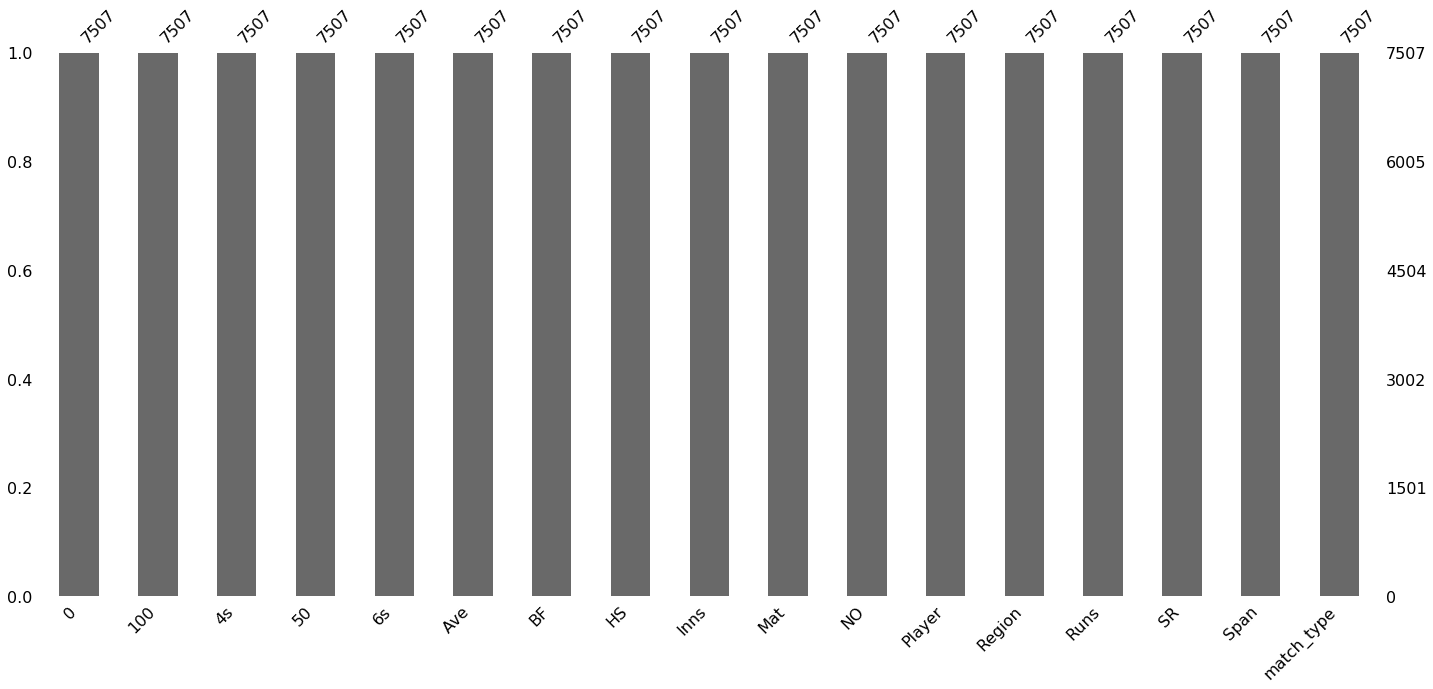

In [15]:
msno.bar(batters_data);

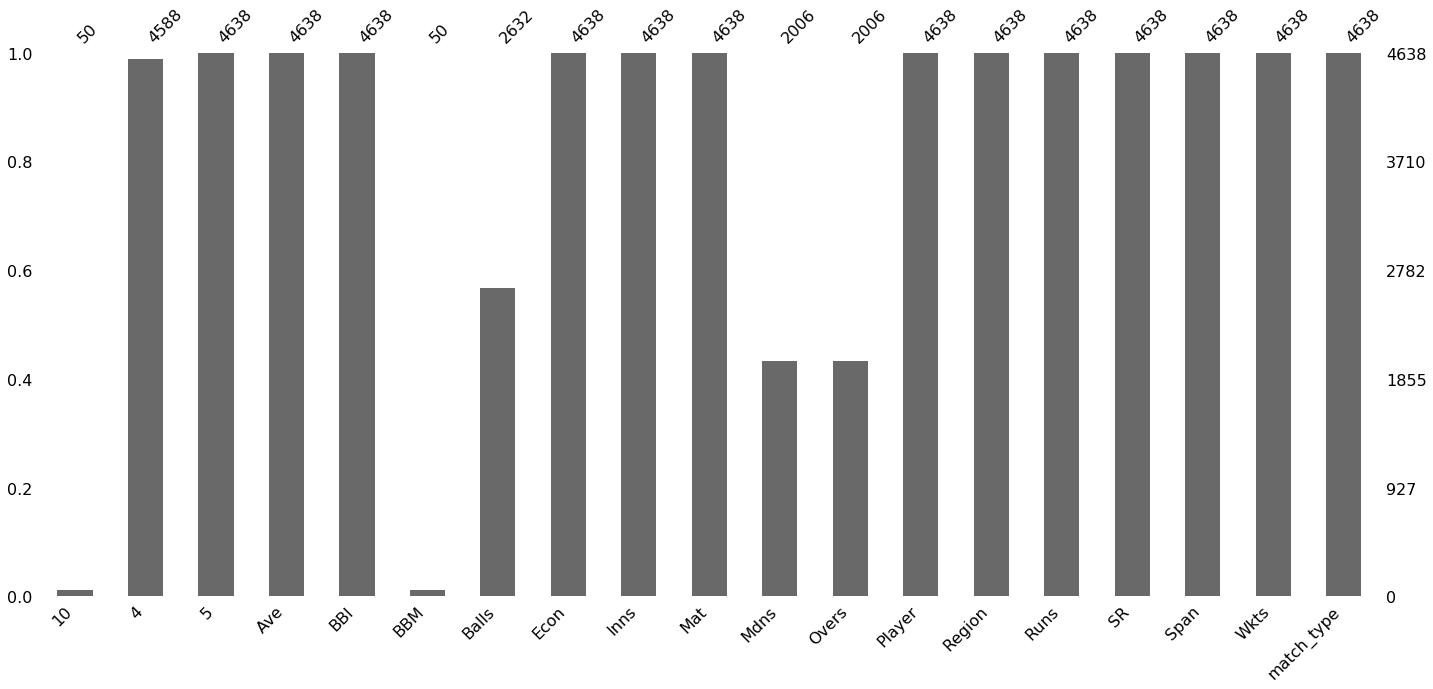

In [16]:
msno.bar(ballers_data);

In [17]:
ballers_data['10'] = ballers_data['10'].fillna(0)
ballers_data['4'] = ballers_data['4'].fillna(0)
ballers_data['BBM'] = ballers_data['BBM'].fillna(0)
ballers_data['Balls'] = ballers_data['Balls'].fillna(0)
ballers_data['Mdns'] = ballers_data['Mdns'].fillna(0)
ballers_data['Overs'] = ballers_data['Overs'].fillna(0)

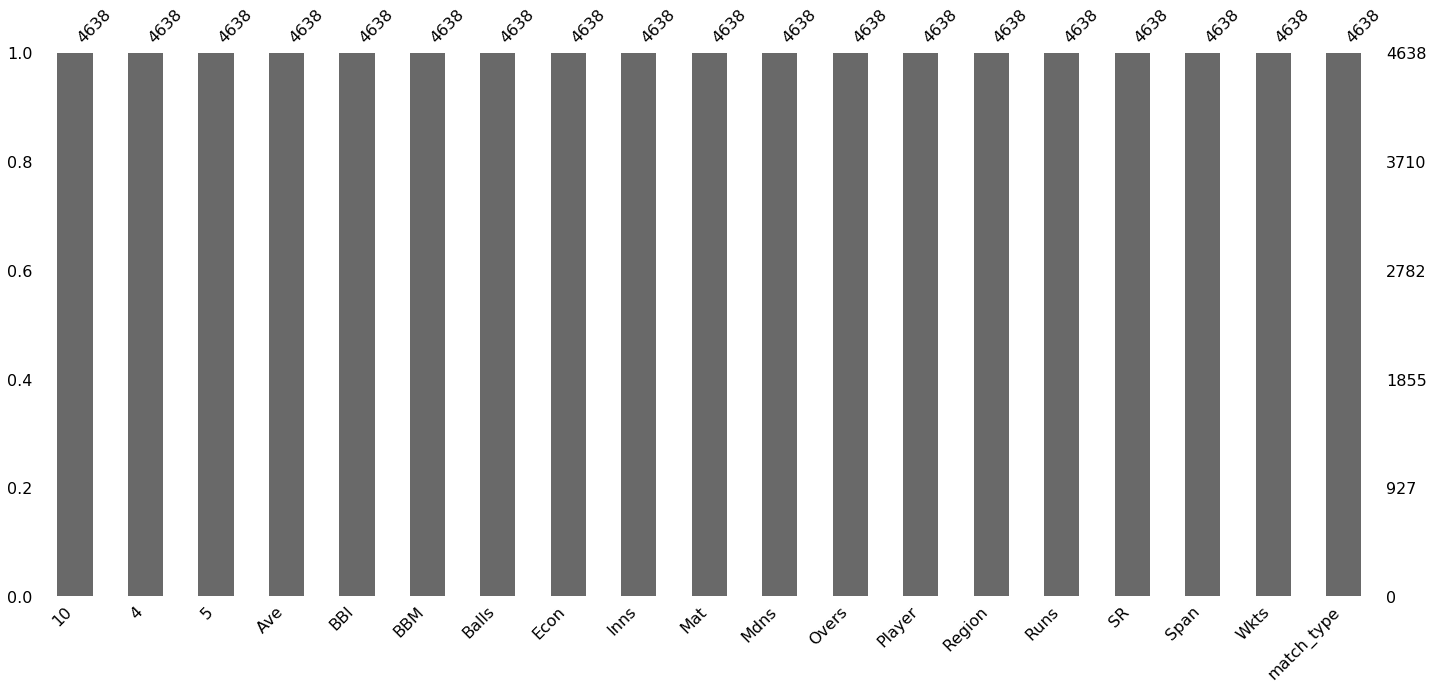

In [18]:
msno.bar(ballers_data);

In [19]:
fielders_data.dtypes

Ct            object
Ct Fi         object
Ct Wk         object
D/I           object
Dis           object
Inns          object
MD            object
Mat            int64
Player        object
Region        object
Span          object
St            object
match_type    object
dtype: object

In [20]:
fielders_data.Ct = fielders_data.Ct.apply(lambda x: int(x) if x != '-' else 0)
fielders_data['Ct Fi'] = fielders_data['Ct Fi'].apply(lambda x: int(x) if x != '-' else 0)
fielders_data['Ct Wk'] = fielders_data['Ct Wk'].apply(lambda x: int(x) if x != '-' else 0)
fielders_data['D/I'] = fielders_data['D/I'].apply(lambda x: float(x) if x != '-' else 0)
fielders_data['Dis'] = fielders_data['Dis'].apply(lambda x: int(x) if x != '-' else 0)
fielders_data['Inns'] = fielders_data['Inns'].apply(lambda x: int(x) if x != '-' else 0)
fielders_data['St'] = fielders_data['St'].apply(lambda x: int(x) if x != '-' else 0)

In [21]:
 fielders_data.dtypes

Ct              int64
Ct Fi           int64
Ct Wk           int64
D/I           float64
Dis             int64
Inns            int64
MD             object
Mat             int64
Player         object
Region         object
Span           object
St              int64
match_type     object
dtype: object

In [22]:
ballers_data.dtypes

10            float64
4              object
5              object
Ave            object
BBI            object
BBM            object
Balls          object
Econ           object
Inns           object
Mat             int64
Mdns           object
Overs          object
Player         object
Region         object
Runs           object
SR             object
Span           object
Wkts           object
match_type     object
dtype: object

In [23]:
ballers_data['4'] = ballers_data['4'].apply(lambda x: int(x) if x != '-' else 0)
ballers_data['5'] = ballers_data['5'].apply(lambda x: int(x) if x != '-' else 0)
ballers_data['Ave'] = ballers_data['Ave'].apply(lambda x: float(x) if x != '-' else 0)
ballers_data['Balls'] = ballers_data['Balls'].apply(lambda x: int(x) if x != '-' else 0)
ballers_data['Mdns'] = ballers_data['Mdns'].apply(lambda x: int(x) if x != '-' else 0)
ballers_data['Overs'] = ballers_data['Overs'].apply(lambda x: float(x) if x != '-' else 0)
ballers_data['Runs'] = ballers_data['Runs'].apply(lambda x: int(x) if x != '-' else 0)
ballers_data['SR'] = ballers_data['SR'].apply(lambda x: float(x) if x != '-' else 0)
ballers_data['Wkts'] = ballers_data['Wkts'].apply(lambda x: int(x) if x != '-' else 0)

In [24]:
ballers_data.dtypes

10            float64
4               int64
5               int64
Ave           float64
BBI            object
BBM            object
Balls           int64
Econ           object
Inns           object
Mat             int64
Mdns            int64
Overs         float64
Player         object
Region         object
Runs            int64
SR            float64
Span           object
Wkts            int64
match_type     object
dtype: object

In [25]:
batters_data.dtypes

0             object
100           object
4s            object
50            object
6s            object
Ave           object
BF            object
HS            object
Inns          object
Mat            int64
NO            object
Player        object
Region        object
Runs          object
SR            object
Span          object
match_type    object
dtype: object

In [26]:
batters_data['0'] = batters_data['0'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['100'] = batters_data['100'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['4s'] = batters_data['4s'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['50'] = batters_data['50'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['6s'] = batters_data['6s'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['Ave'] = batters_data['Ave'].apply(lambda x: float(x) if x != '-' else 0)
batters_data['BF'] = batters_data['BF'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['HS'] = batters_data['HS'].apply(lambda x: int(x.replace('*','')) if x != '-' else 0)
batters_data['Inns'] = batters_data['Inns'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['NO'] = batters_data['NO'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['Runs'] = batters_data['Runs'].apply(lambda x: int(x) if x != '-' else 0)
batters_data['SR'] = batters_data['SR'].apply(lambda x: float(x) if x != '-' else 0)

In [27]:
batters_data.dtypes

0               int64
100             int64
4s              int64
50              int64
6s              int64
Ave           float64
BF              int64
HS              int64
Inns            int64
Mat             int64
NO              int64
Player         object
Region         object
Runs            int64
SR            float64
Span           object
match_type     object
dtype: object

In [28]:
print('---------\nSkewness:\n---------\n',fielders_data.skew(),'\n---------\nKurtosis:\n---------\n',fielders_data.kurtosis())

---------
Skewness:
---------
 Ct        6.467235
Ct Fi     5.291784
Ct Wk    10.361803
D/I       2.176924
Dis       6.774431
Inns      3.811255
Mat       6.046093
St       14.231075
dtype: float64 
---------
Kurtosis:
---------
 Ct        59.688591
Ct Fi     35.952302
Ct Wk    134.809802
D/I        6.910681
Dis       65.115643
Inns      19.201323
Mat       53.902892
St       289.202824
dtype: float64


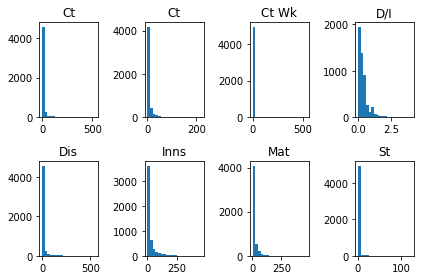

In [29]:
ax = plt.subplot(2,4,1)
ax.hist(fielders_data.Ct,bins=20);
ax.set_title('Ct')

ax = plt.subplot(2,4,2)
ax.hist(fielders_data['Ct Fi'],bins=20);
ax.set_title('Ct')

ax = plt.subplot(2,4,3)
ax.hist(fielders_data['Ct Wk'],bins=20);
ax.set_title('Ct Wk')

ax = plt.subplot(2,4,4)
ax.hist(fielders_data['D/I'],bins=20);
ax.set_title('D/I')

ax = plt.subplot(2,4,5)
ax.hist(fielders_data['Dis'],bins=20);
ax.set_title('Dis')

ax = plt.subplot(2,4,6)
ax.hist(fielders_data['Inns'],bins=20);
ax.set_title('Inns')

ax = plt.subplot(2,4,7)
ax.hist(fielders_data['Mat'],bins=20);
ax.set_title('Mat')

ax = plt.subplot(2,4,8)
ax.hist(fielders_data['St'],bins=20);
ax.set_title('St')

plt.tight_layout()

In [30]:
print('---------\nSkewness:\n---------\n',ballers_data.skew(),'\n---------\nKurtosis:\n---------\n',ballers_data.kurtosis())

---------
Skewness:
---------
 10       23.917904
4         6.079559
5        13.153398
Ave       2.058950
Balls     7.575813
Mat       3.784603
Mdns      6.110074
Overs     5.367910
Runs      5.381310
SR        1.847024
Wkts      6.050648
dtype: float64 
---------
Kurtosis:
---------
 10       793.191256
4         49.752745
5        235.388463
Ave        8.777856
Balls     73.966025
Mat       18.442209
Mdns      45.726801
Overs     38.617787
Runs      36.773738
SR         6.331235
Wkts      47.660282
dtype: float64


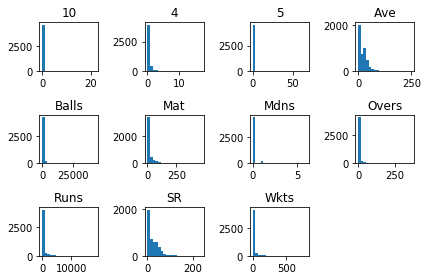

In [31]:
ax = plt.subplot(3,4,1)
ax.hist(ballers_data['10'],bins=20);
ax.set_title('10')

ax = plt.subplot(3,4,2)
ax.hist(ballers_data['4'],bins=20);
ax.set_title('4')

ax = plt.subplot(3,4,3)
ax.hist(ballers_data['5'],bins=20);
ax.set_title('5')

ax = plt.subplot(3,4,4)
ax.hist(ballers_data['Ave'],bins=20);
ax.set_title('Ave')

ax = plt.subplot(3,4,5)
ax.hist(ballers_data['Balls'],bins=20);
ax.set_title('Balls')

ax = plt.subplot(3,4,6)
ax.hist(ballers_data['Mat'],bins=20);
ax.set_title('Mat')

ax = plt.subplot(3,4,7)
ax.hist(ballers_data['Mdns'],bins=20);
ax.set_title('Mdns')

ax = plt.subplot(3,4,8)
ax.hist(ballers_data['Overs'],bins=20);
ax.set_title('Overs')

ax = plt.subplot(3,4,9)
ax.hist(ballers_data['Runs'],bins=20);
ax.set_title('Runs')

ax = plt.subplot(3,4,10)
ax.hist(ballers_data['SR'],bins=20);
ax.set_title('SR')

ax = plt.subplot(3,4,11)
ax.hist(ballers_data['Wkts'],bins=20);
ax.set_title('Wkts')

plt.tight_layout()

In [32]:
print('---------\nSkewness:\n---------\n',batters_data.skew(),'\n---------\nKurtosis:\n---------\n',batters_data.kurtosis())

---------
Skewness:
---------
 0       3.208915
100     6.798509
4s      8.738411
50      5.054434
6s      9.397989
Ave     1.485551
BF      7.257116
HS      1.858939
Inns    3.660086
Mat     4.201362
NO      4.042179
Runs    4.852983
SR      0.835542
dtype: float64 
---------
Kurtosis:
---------
 0        15.111313
100      59.761941
4s       93.676430
50       32.928021
6s      112.050681
Ave       5.919030
BF       66.434722
HS        4.344771
Inns     17.885851
Mat      24.364767
NO       23.075927
Runs     30.169855
SR        0.555960
dtype: float64


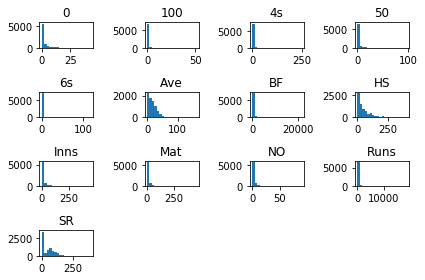

In [33]:
ax = plt.subplot(4,4,1)
ax.hist(batters_data['0'],bins=20);
ax.set_title('0')

ax = plt.subplot(4,4,2)
ax.hist(batters_data['100'],bins=20);
ax.set_title('100')

ax = plt.subplot(4,4,3)
ax.hist(batters_data['4s'],bins=20);
ax.set_title('4s')

ax = plt.subplot(4,4,4)
ax.hist(batters_data['50'],bins=20);
ax.set_title('50')

ax = plt.subplot(4,4,5)
ax.hist(batters_data['6s'],bins=20);
ax.set_title('6s')

ax = plt.subplot(4,4,6)
ax.hist(batters_data['Ave'],bins=20);
ax.set_title('Ave')

ax = plt.subplot(4,4,7)
ax.hist(batters_data['BF'],bins=20);
ax.set_title('BF')

ax = plt.subplot(4,4,8)
ax.hist(batters_data['HS'],bins=20);
ax.set_title('HS')

ax = plt.subplot(4,4,9)
ax.hist(batters_data['Inns'],bins=20);
ax.set_title('Inns')

ax = plt.subplot(4,4,10)
ax.hist(batters_data['Mat'],bins=20);
ax.set_title('Mat')

ax = plt.subplot(4,4,11)
ax.hist(batters_data['NO'],bins=20);
ax.set_title('NO')

ax = plt.subplot(4,4,12)
ax.hist(batters_data['Runs'],bins=20);
ax.set_title('Runs')

ax = plt.subplot(4,4,13)
ax.hist(batters_data['SR'],bins=20);
ax.set_title('SR')

plt.tight_layout()

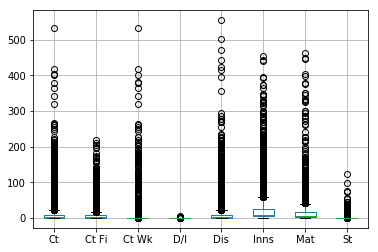

In [34]:
fielders_data.boxplot();

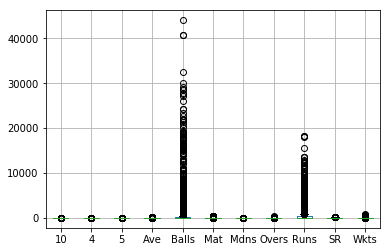

In [35]:
ballers_data.boxplot();

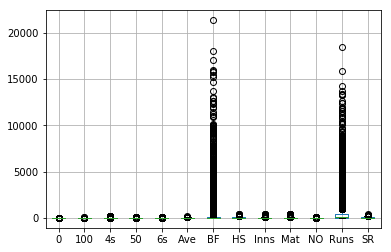

In [36]:
batters_data.boxplot();

In [37]:
fielders_data.describe()

,Ct,Ct Fi,Ct Wk,D/I,Dis,Inns,Mat,St
count,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000
mean,11.500297,7.724936,3.775361,0.361302,12.088986,25.549140,17.188056,0.588689
std,30.738511,18.437997,25.008965,0.400687,33.326521,44.767066,32.797428,4.133848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.076000,1.000000,4.000000,3.000000,0.000000
50%,2.000000,2.000000,0.000000,0.265000,2.000000,9.000000,6.000000,0.000000
75%,9.000000,7.000000,0.000000,0.500000,9.000000,26.000000,18.000000,0.000000
max,532.000000,218.000000,532.000000,4.000000,555.000000,456.000000,463.000000,123.000000


In [38]:
ballers_data.describe()

,10,4,5,Ave,Balls,Mat,Mdns,Overs,Runs,SR,Wkts
count,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000
mean,0.037301,0.334411,0.325140,21.040097,713.405994,25.905347,0.101337,8.054657,543.600474,22.755261,18.144890
std,0.520560,1.153735,2.328143,24.181059,2714.866359,46.807212,0.459808,24.532722,1496.448199,26.639593,53.498531
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,19.125000,0.000000,8.000000,0.000000,0.000000,68.000000,17.400000,2.000000
75%,0.000000,0.000000,0.000000,33.522500,215.500000,26.000000,0.000000,3.000000,345.000000,38.000000,11.000000
max,22.000000,17.000000,67.000000,251.000000,44039.000000,463.000000,6.000000,361.200000,18355.000000,234.000000,800.000000


In [39]:
batters_data.describe()

,0,100,4s,50,6s,Ave,BF,HS,Inns,Mat,NO,Runs,SR
count,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000,7507.000000
mean,2.233116,0.807113,3.052351,2.681098,1.232050,17.199338,330.309311,50.162515,23.244439,22.343679,3.747436,555.846543,44.526871
std,3.659066,3.224083,15.018828,7.627629,6.340647,14.028155,1261.176762,54.147291,40.792245,39.731726,7.000639,1385.948540,47.945557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,6.630000,0.000000,11.000000,3.000000,3.000000,0.000000,18.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,14.830000,10.000000,32.000000,7.000000,8.000000,1.000000,85.000000,40.000000
75%,3.000000,0.000000,0.000000,1.000000,0.000000,25.000000,117.000000,71.000000,24.000000,24.000000,4.000000,385.000000,78.950000
max,43.000000,51.000000,247.000000,96.000000,120.000000,160.500000,21367.000000,400.000000,452.000000,463.000000,89.000000,18426.000000,400.000000


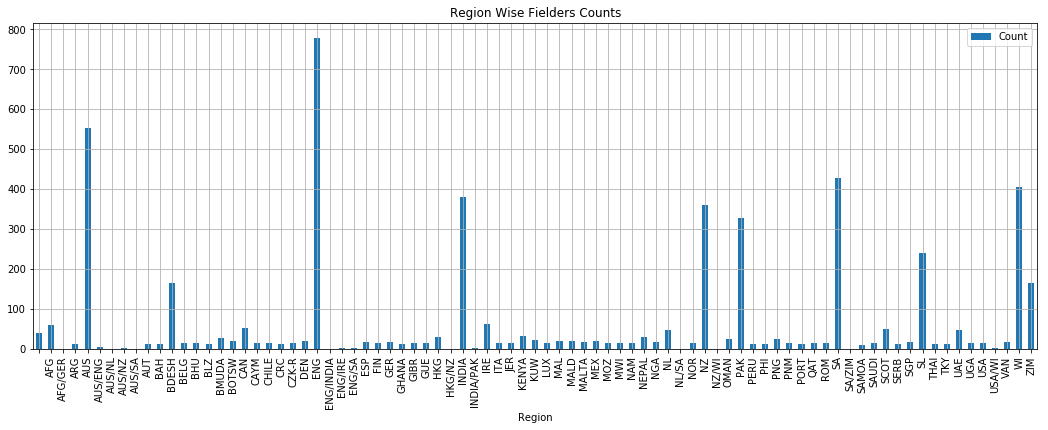

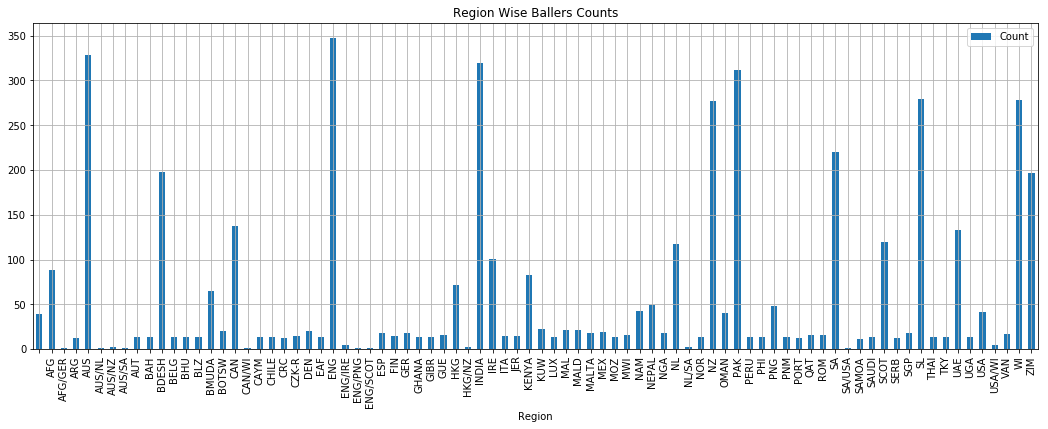

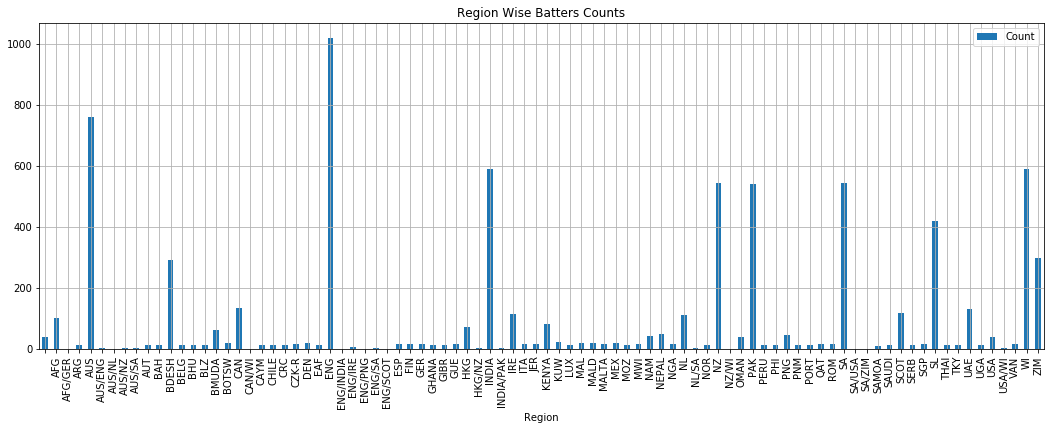

In [40]:
grp = fielders_data.groupby(['Region'])
agg = grp.aggregate({'Player':'count'})
agg.reset_index(inplace=True)
agg.columns = ['Region','Count']
agg.plot.bar(x='Region',y='Count',rot=90,figsize=(18,6),title='Region Wise Fielders Counts',grid=True);

grp = ballers_data.groupby(['Region'])
agg = grp.aggregate({'Player':'count'})
agg.reset_index(inplace=True)
agg.columns = ['Region','Count']
agg.plot.bar(x='Region',y='Count',rot=90,figsize=(18,6),title='Region Wise Ballers Counts',grid=True);

grp = batters_data.groupby(['Region'])
agg = grp.aggregate({'Player':'count'})
agg.reset_index(inplace=True)
agg.columns = ['Region','Count']
agg.plot.bar(x='Region',y='Count',rot=90,figsize=(18,6),title='Region Wise Batters Counts',grid=True);

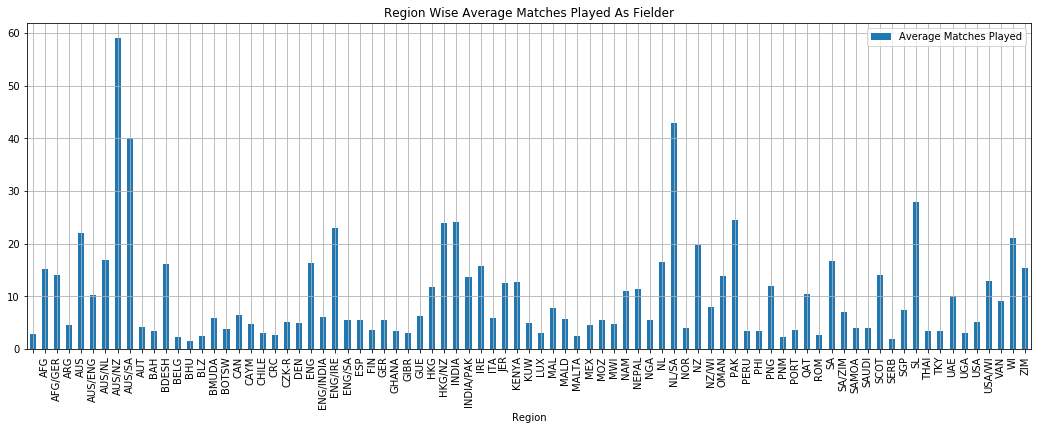

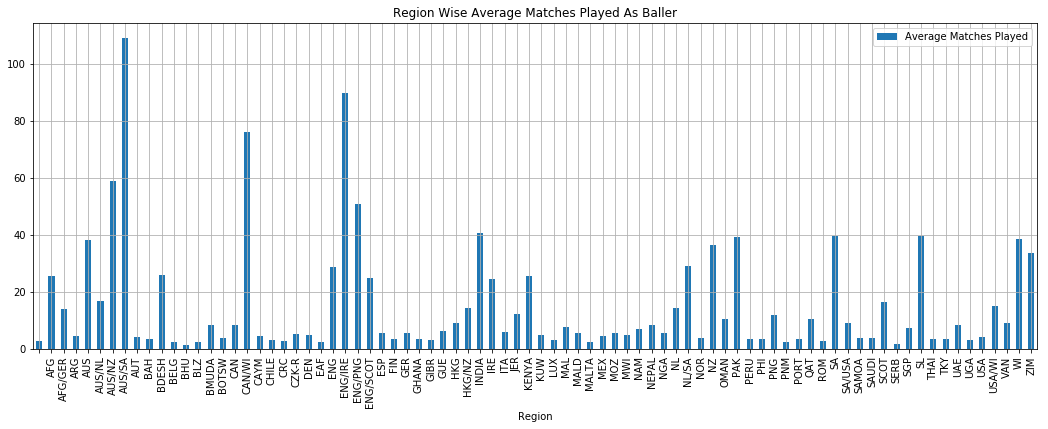

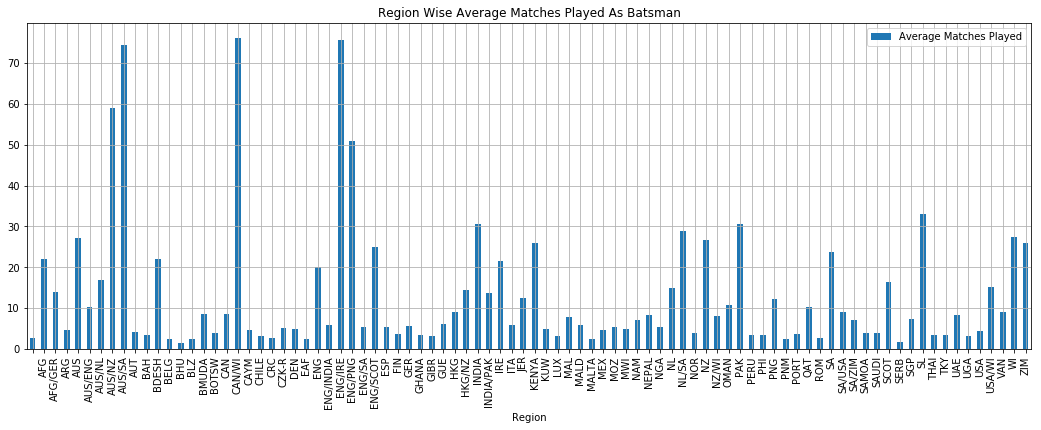

In [41]:
grp = fielders_data.groupby(['Region'])
agg = grp.aggregate({'Mat':'mean'})
agg.reset_index(inplace=True)
agg.columns = ['Region','Average Matches Played']
agg.plot.bar(x='Region',y='Average Matches Played',rot=90,figsize=(18,6),title='Region Wise Average Matches Played As Fielder',grid=True);

grp = ballers_data.groupby(['Region'])
agg = grp.aggregate({'Mat':'mean'})
agg.reset_index(inplace=True)
agg.columns = ['Region','Average Matches Played']
agg.plot.bar(x='Region',y='Average Matches Played',rot=90,figsize=(18,6),title='Region Wise Average Matches Played As Baller',grid=True);

grp = batters_data.groupby(['Region'])
agg = grp.aggregate({'Mat':'mean'})
agg.reset_index(inplace=True)
agg.columns = ['Region','Average Matches Played']
agg.plot.bar(x='Region',y='Average Matches Played',rot=90,figsize=(18,6),title='Region Wise Average Matches Played As Batsman',grid=True);

In [42]:
batters_data['Percentage of 100'] = (batters_data['100']/batters_data['Runs'])*100
batters_data['Percentage of 50'] = (batters_data['50']/batters_data['Runs'])*100

batters_data['Percentage of 100'].fillna(0,inplace=True)
batters_data['Percentage of 50'].fillna(0,inplace=True)

batters_data['Percentage of 100'] = batters_data['Percentage of 100'].apply(lambda x:round(x,3))
batters_data['Percentage of 50'] = batters_data['Percentage of 50'].apply(lambda x:round(x,3))

to_plot = batters_data[['Player','Region','match_type','Runs','50','Percentage of 50','100','Percentage of 100']]
to_plot

,Player,Region,match_type,Runs,50,Percentage of 50,100,Percentage of 100
0,SR TENDULKAR,INDIA,odi,18426,96,0.521,49,0.266
1,KC SANGAKKARA,SL,odi,14234,93,0.653,25,0.176
2,RT PONTING,AUS,odi,13704,82,0.598,30,0.219
3,ST JAYASURIYA,SL,odi,13430,68,0.506,28,0.208
4,DPMD JAYAWARDENE,SL,odi,12650,77,0.609,19,0.150
...,...,...,...,...,...,...,...,...
2996,CA SNEDDEN,NZ,test,0,0,0.000,0,0.000
2997,VN SWAMY,INDIA,test,0,0,0.000,0,0.000
2998,USMAN SHINWARI,PAK,test,0,0,0.000,0,0.000
2999,CM WILLOUGHBY,SA,test,0,0,0.000,0,0.000


In [43]:
# batters_data.groupby([])

In [44]:
def get_class(x):
    cls = ''
    if (0 <= x) and (x < 10):
        cls='0 - 9'
    elif (10 <= x) and (x < 20):
        cls = '10 - 19'
    elif (20 <= x) and (x < 30):
        cls = '20 - 29'
    elif (30 <= x) and (x < 40):
        cls = '30 - 39'
    elif (40 <= x) and (x < 50):
        cls = '40 - 49'
    elif (50 <= x) and (x < 60):
        cls='50 - 59'
    return cls

In [45]:
x = batters_data[['Player','100']].copy()
x['class'] = x['100'].apply(lambda x : get_class(x))
x

,Player,100,class
0,SR TENDULKAR,49,40 - 49
1,KC SANGAKKARA,25,20 - 29
2,RT PONTING,30,30 - 39
3,ST JAYASURIYA,28,20 - 29
4,DPMD JAYAWARDENE,19,10 - 19
...,...,...,...
2996,CA SNEDDEN,0,0 - 9
2997,VN SWAMY,0,0 - 9
2998,USMAN SHINWARI,0,0 - 9
2999,CM WILLOUGHBY,0,0 - 9


In [46]:
grp = x.groupby(['class']).aggregate({'Player':'count'}).reset_index()
grp.columns = ['Century Class','Count of Players']
grp

,Century Class,Count of Players
0,0 - 9,7324
1,10 - 19,124
2,20 - 29,43
3,30 - 39,11
4,40 - 49,4
5,50 - 59,1


In [47]:
odi_filter = batters_data.match_type=='odi'
test_filter = batters_data.match_type=='test'
t20_filter = batters_data.match_type=='t20'

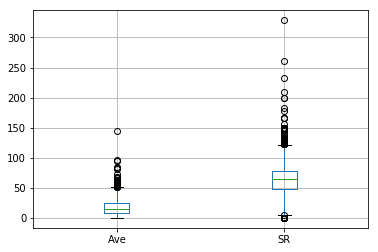

In [48]:
batters_data[odi_filter][['Ave','SR']].boxplot();

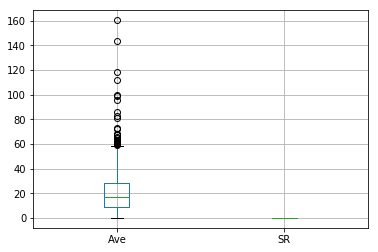

In [49]:
batters_data[test_filter][['Ave','SR']].boxplot();

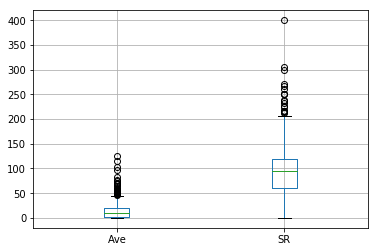

In [50]:
batters_data[t20_filter][['Ave','SR']].boxplot();

In [51]:
odi_filter = ballers_data.match_type=='odi'
test_filter = ballers_data.match_type=='test'
t20_filter = ballers_data.match_type=='t20'

min_odi_wkts = ballers_data[odi_filter]['Wkts'].min()
avg_odi_wkts = ballers_data[odi_filter]['Wkts'].mean()
max_odi_wkts = ballers_data[odi_filter]['Wkts'].max()

min_test_wkts = ballers_data[test_filter]['Wkts'].min()
avg_test_wkts = ballers_data[test_filter]['Wkts'].mean()
max_test_wkts = ballers_data[test_filter]['Wkts'].max()

min_t20_wkts = ballers_data[t20_filter]['Wkts'].min()
avg_t20_wkts = ballers_data[t20_filter]['Wkts'].mean()
max_t20_wkts = ballers_data[t20_filter]['Wkts'].max()

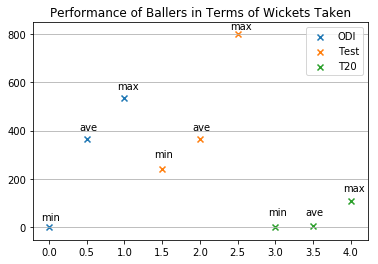

In [52]:
plt.scatter([0,0.5,1],[min_odi_wkts,avg_test_wkts,max_odi_wkts],marker='x');
plt.scatter([1.5,2,2.5],[min_test_wkts,avg_test_wkts,max_test_wkts],marker='x');
plt.scatter([3,3.5,4],[min_t20_wkts,avg_t20_wkts,max_t20_wkts],marker='x');
plt.grid(axis='y');
plt.title('Performance of Ballers in Terms of Wickets Taken')
plt.legend(['ODI','Test','T20']);

plt.text(-0.1, 30, 'min');
plt.text(0.4, 400, 'ave');
plt.text(0.9, 570, 'max');
plt.text(1.4, 290, 'min');
plt.text(1.9, 400, 'ave');
plt.text(2.4, 820, 'max');
plt.text(2.9, 50, 'min');
plt.text(3.4, 50, 'ave');
plt.text(3.9, 150, 'max');

In [53]:
min_odi_wkts

0

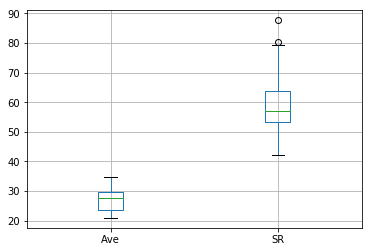

In [54]:
ballers_data[test_filter][['Ave','SR']].boxplot();

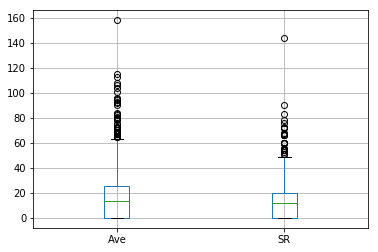

In [55]:
ballers_data[t20_filter][['Ave','SR']].boxplot();

In [56]:
ballers_data.columns

Index(['10', '4', '5', 'Ave', 'BBI', 'BBM', 'Balls', 'Econ', 'Inns', 'Mat',
       'Mdns', 'Overs', 'Player', 'Region', 'Runs', 'SR', 'Span', 'Wkts',
       'match_type'],
      dtype='object')

In [57]:
data = batters_data.groupby(['Player']).aggregate({'Mat':'sum','Runs':'sum'})
data.reset_index(inplace=True)
data.sort_values(by='Mat',inplace=True,ascending=False)
data.head(10)

,Player,Mat,Runs
4377,SR TENDULKAR,664,34357
1196,DPMD JAYAWARDENE,652,25957
2493,KC SANGAKKARA,594,28016
4402,ST JAYASURIYA,586,21032
3950,RT PONTING,560,27483
3115,MS DHONI,538,17266
4225,SHAHID AFRIDI,524,11196
2248,JH KALLIS,519,25534
3624,R DRAVID,509,24208
2010,INZAMAM-UL-HAQ,499,20580


In [58]:
data = ballers_data.groupby(['Player']).aggregate({'Wkts':'sum'})
data.reset_index(inplace=True)
data.sort_values(by='Wkts',inplace=True,ascending=False)
data.head(10)

,Player,Wkts
1828,M MURALITHARAN,1347
3026,SK WARNE,1001
24,A KUMBLE,956
1051,GD MCGRATH,949
3373,WASIM AKRAM,916
1501,JM ANDERSON,864
3045,SM POLLOCK,829
3365,WAQAR YOUNIS,789
3400,WPUJC VAAS,761
568,CA WALSH,746


In [59]:
print('Pearson Correlation Between Runs and Innings:',sp.stats.pearsonr(batters_data.Runs,batters_data.Inns)[0])
print('Pearson Correlation Between Average and Strike Rate (ODI):',sp.stats.pearsonr(batters_data[batters_data['match_type']=='odi'].fillna(0).Ave,batters_data[batters_data['match_type']=='odi'].fillna(0).SR)[0])
print('Pearson Correlation Between Average and Strike Rate (T20):',sp.stats.pearsonr(batters_data[batters_data['match_type']=='t20'].fillna(0).Ave,batters_data[batters_data['match_type']=='t20'].fillna(0).SR)[0])
print('Pearson Correlation Between Average and Strike Rate (Test):',sp.stats.pearsonr(batters_data[batters_data['match_type']=='test'].fillna(0).Ave,batters_data[batters_data['match_type']=='test'].fillna(0).SR)[0]);

Pearson Correlation Between Runs and Innings: 0.9291668105423827
Pearson Correlation Between Average and Strike Rate (ODI): 0.4226491761518426
Pearson Correlation Between Average and Strike Rate (T20): 0.5710723639930254
Pearson Correlation Between Average and Strike Rate (Test): nan


/home/naqi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [60]:
batters_data.corr()

,0,100,4s,50,6s,Ave,BF,HS,Inns,Mat,NO,Runs,SR,Percentage of 100,Percentage of 50
0,1.000000,0.465916,0.007557,0.573591,0.010548,0.213983,0.421063,0.488942,0.809787,0.746762,0.715413,0.629175,-0.115514,0.262409,0.214673
100,0.465916,1.000000,-0.033851,0.818850,-0.027984,0.439709,0.400225,0.668148,0.732375,0.547218,0.367336,0.899282,-0.099683,0.566414,0.220363
4s,0.007557,-0.033851,1.000000,0.045102,0.883090,0.123287,0.050882,0.080736,0.063362,0.085468,0.051864,0.039765,0.337118,-0.028685,0.137683
50,0.573591,0.818850,0.045102,1.000000,0.039308,0.477266,0.717885,0.669182,0.892867,0.771779,0.533983,0.969770,-0.026828,0.434388,0.405389
6s,0.010548,-0.027984,0.883090,0.039308,1.000000,0.122392,0.046237,0.081845,0.063915,0.088157,0.065658,0.037815,0.343510,-0.007563,0.124180
Ave,0.213983,0.439709,0.123287,0.477266,0.122392,1.000000,0.260950,0.758260,0.421283,0.314384,0.213695,0.491333,0.073547,0.579440,0.589696
BF,0.421063,0.400225,0.050882,0.717885,0.046237,0.260950,1.000000,0.304054,0.687681,0.790835,0.519084,0.649962,0.186759,0.171591,0.249406
HS,0.488942,0.668148,0.080736,0.669182,0.081845,0.758260,0.304054,1.000000,0.672566,0.494074,0.329751,0.724065,-0.101134,0.718973,0.577631
Inns,0.809787,0.732375,0.063362,0.892867,0.063915,0.421283,0.687681,0.672566,1.000000,0.919717,0.764192,0.929167,-0.028550,0.396334,0.335874
Mat,0.746762,0.547218,0.085468,0.771779,0.088157,0.314384,0.790835,0.494074,0.919717,1.000000,0.837722,0.787984,0.123390,0.258321,0.261218


In [61]:
X = batters_data[['Mat']]
y = batters_data[['100']]

In [62]:
clf = LinearRegression()
clf.fit(X,y);
y_pred = clf.predict(X)

(0, 100)

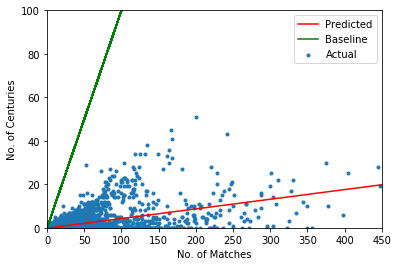

In [63]:
plt.scatter(X,y,marker='.')
plt.plot(X,y_pred,'r');
plt.plot(X,X,'g');
plt.legend(['Predicted','Baseline','Actual'])
plt.xlabel('No. of Matches')
plt.ylabel('No. of Centuries');
plt.xlim(0,450)
plt.ylim(0,100)

In [64]:
print('Coefficient of Determination:',clf.score(y,y_pred))

Coefficient of Determination: -0.2116321782947328


In [65]:
print('Regression Coefficient:',clf.coef_[0][0])

Regression Coefficient: 0.044404721651538734


In [66]:
print('Regression Intercept:',clf.intercept_[0])

Regression Intercept: -0.18505149613683192


In [67]:
batters_data.iloc[16]

0                                 7
100                              25
4s                                0
50                               53
6s                                0
Ave                            53.5
BF                             9473
HS                              176
Inns                            218
Mat                             228
NO                               39
Player               AB DE VILLIERS
Region                           SA
Runs                           9577
SR                           101.09
Span                      2005-2018
match_type                      odi
Percentage of 100             0.261
Percentage of 50              0.553
Name: 16, dtype: object

In [68]:
print('Predicted Centuries:', clf.predict(np.array([[228]]))[0][0])

Predicted Centuries: 9.939225040413998


In [69]:
ballers_data.corr()

,10,4,5,Ave,Balls,Mat,Mdns,Overs,Runs,SR,Wkts
10,1.000000,-0.020774,0.896792,0.014351,0.672984,0.113328,-0.015795,-0.023531,0.533460,0.093607,0.590397
4,-0.020774,1.000000,0.142326,0.086397,0.401496,0.469756,0.036110,0.052657,0.572447,0.130582,0.581860
5,0.896792,0.142326,1.000000,0.033597,0.864757,0.238460,-0.020511,-0.028893,0.741989,0.142323,0.799127
Ave,0.014351,0.086397,0.033597,1.000000,0.117008,0.125658,0.021202,0.060458,0.168064,0.939009,0.122298
Balls,0.672984,0.401496,0.864757,0.117008,1.000000,0.476480,-0.057926,-0.086295,0.955554,0.257420,0.957959
Mat,0.113328,0.469756,0.238460,0.125658,0.476480,1.000000,-0.002280,0.016316,0.587730,0.189196,0.542681
Mdns,-0.015795,0.036110,-0.020511,0.021202,-0.057926,-0.002280,1.000000,0.663604,0.005304,-0.020797,0.033094
Overs,-0.023531,0.052657,-0.028893,0.060458,-0.086295,0.016316,0.663604,1.000000,0.013480,-0.027778,0.050618
Runs,0.533460,0.572447,0.741989,0.168064,0.955554,0.587730,0.005304,0.013480,1.000000,0.289399,0.981355
SR,0.093607,0.130582,0.142323,0.939009,0.257420,0.189196,-0.020797,-0.027778,0.289399,1.000000,0.242073


In [70]:
X = ballers_data[['Mat']]
y = ballers_data[['Wkts']]

In [71]:
clf = LinearRegression()
clf.fit(X,y);
y_pred = clf.predict(X)

(0, 650)

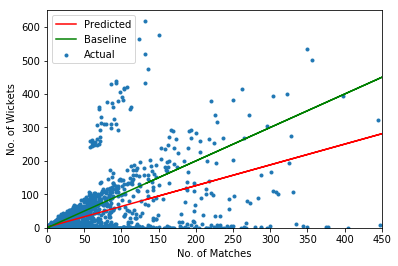

In [72]:
plt.scatter(X,y,marker='.')
plt.plot(X,y_pred,'r');
plt.plot(X,X,'g');
plt.legend(['Predicted','Baseline','Actual'])
plt.xlabel('No. of Matches')
plt.ylabel('No. of Wickets');
plt.xlim(0,450)
plt.ylim(0,650)

In [73]:
print('Coefficient of Determination:',clf.score(y,y_pred))

Coefficient of Determination: -0.09331942461420217


In [74]:
print('Regression Coefficient:',clf.coef_[0][0])

Regression Coefficient: 0.6202603600895505


In [75]:
print('Regression Intercept:',clf.intercept_[0])

Regression Intercept: 2.076830098232122


In [76]:
ballers_data.iloc[50]

10                     0
4                      1
5                      2
Ave                19.44
BBI                  5/6
BBM                    0
Balls                  0
Econ                7.23
Inns                  79
Mat                   79
Mdns                   1
Overs              284.5
Player        SL MALINGA
Region                SL
Runs                2061
SR                  16.1
Span           2006-2019
Wkts                 106
match_type           t20
Name: 0, dtype: object

In [77]:
print('Predicted Wickets:', clf.predict(np.array([[79]]))[0][0])

Predicted Wickets: 51.077398545306615


In [78]:
grp = fielders_data.groupby(['match_type']).aggregate({'Ct':'sum','Ct Fi':'sum','Ct Wk':'sum'})
grp.reset_index(inplace=True)
grp

,match_type,Ct,Ct Fi,Ct Wk
0,odi,8265,2863,5402
1,t20,7526,6369,1157
2,test,42366,29833,12533


In [79]:
grpt = grp.transpose()
grpt.columns = grpt.iloc[0,:]
grpt.index = range(4)
grpt.drop(index=0,inplace=True)
grpt.index = range(3)
grpt.columns = ['odi','t20','test']
grpt

,odi,t20,test
0,8265,7526,42366
1,2863,6369,29833
2,5402,1157,12533


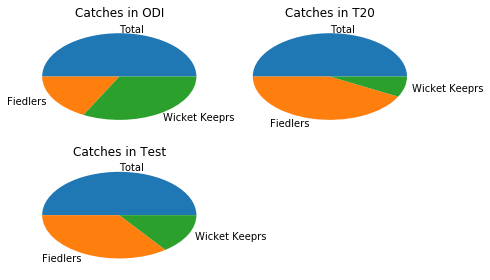

In [80]:
ax = plt.subplot(2,2,1)
ax.pie(grpt.iloc[:,0],labels=['Total','Fiedlers','Wicket Keeprs'])
ax.set_title('Catches in ODI')

ax = plt.subplot(2,2,2)
ax.pie(grpt.iloc[:,1],labels=['Total','Fiedlers','Wicket Keeprs'])
ax.set_title('Catches in T20')

ax = plt.subplot(2,2,3)
ax.pie(grpt.iloc[:,2],labels=['Total','Fiedlers','Wicket Keeprs'])
ax.set_title('Catches in Test')

plt.tight_layout()

In [81]:
print('batting:')
print(batters_data.columns)

print()
print('balling:')
print(ballers_data.columns)

print()
print('fielding:')
print(fielders_data.columns)

batting:
Index(['0', '100', '4s', '50', '6s', 'Ave', 'BF', 'HS', 'Inns', 'Mat', 'NO',
       'Player', 'Region', 'Runs', 'SR', 'Span', 'match_type',
       'Percentage of 100', 'Percentage of 50'],
      dtype='object')

balling:
Index(['10', '4', '5', 'Ave', 'BBI', 'BBM', 'Balls', 'Econ', 'Inns', 'Mat',
       'Mdns', 'Overs', 'Player', 'Region', 'Runs', 'SR', 'Span', 'Wkts',
       'match_type'],
      dtype='object')

fielding:
Index(['Ct', 'Ct Fi', 'Ct Wk', 'D/I', 'Dis', 'Inns', 'MD', 'Mat', 'Player',
       'Region', 'Span', 'St', 'match_type'],
      dtype='object')


In [82]:
 from sklearn.feature_selection import VarianceThreshold

In [83]:
batters_data

,0,100,4s,50,6s,Ave,BF,HS,Inns,Mat,NO,Player,Region,Runs,SR,Span,match_type,Percentage of 100,Percentage of 50
0,20,49,0,96,0,44.83,21367,200,452,463,41,SR TENDULKAR,INDIA,18426,86.23,1989-2012,odi,0.266,0.521
1,15,25,0,93,0,41.98,18048,169,380,404,41,KC SANGAKKARA,SL,14234,78.86,2000-2015,odi,0.176,0.653
2,20,30,0,82,0,42.03,17046,164,365,375,39,RT PONTING,AUS,13704,80.39,1995-2012,odi,0.219,0.598
3,34,28,0,68,0,32.36,14725,189,433,445,18,ST JAYASURIYA,SL,13430,91.20,1989-2011,odi,0.208,0.506
4,28,19,0,77,0,33.37,16020,144,418,448,39,DPMD JAYAWARDENE,SL,12650,78.96,1998-2015,odi,0.150,0.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,0,0,0,0,0.00,0,0,0,1,0,CA SNEDDEN,NZ,0,0.00,1947-1947,test,0.000,0.000
2997,0,0,0,0,0,0.00,0,0,0,1,0,VN SWAMY,INDIA,0,0.00,1955-1955,test,0.000,0.000
2998,0,0,0,0,0,0.00,0,0,0,1,0,USMAN SHINWARI,PAK,0,0.00,2019-2019,test,0.000,0.000
2999,0,0,0,0,0,0.00,0,0,0,2,0,CM WILLOUGHBY,SA,0,0.00,2003-2003,test,0.000,0.000


In [96]:
x = fielders_data.Span.apply(lambda x : int(x.split('-')[0]))

In [97]:
x.min()

1877

In [98]:
x.max()

2019

In [99]:
x = batters_data.Span.apply(lambda x : int(x.split('-')[0]))

In [100]:
x.min()

1877

In [101]:
x.max()

2019

In [105]:
x = ballers_data.Span.apply(lambda x : int(x.split('-')[0]))

In [106]:
x.min()

1951

In [108]:
x.max()

2019